In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   0.101458 -0.430189 -0.036178 -0.341848 -0.775596 -0.061134  0.907429   
  1   0.009695 -0.795976  0.710650  1.147053 -0.200239  1.485476  0.317586   
  2  -0.162250 -0.973380 -0.194912  0.374656 -0.126557 -0.156846 -0.193293   
  3  -0.565738 -0.958493 -0.755318 -0.131383  0.115708  0.200909  0.098967   
  4   0.171486  0.414537  0.404088  0.663105  1.098124  1.144046  0.552326   
  5  -1.279105 -0.231181 -0.455537  0.663652  1.236488  0.725923 -0.079337   
  6  -0.543172 -1.043270 -0.668462  0.091091  0.947968  0.733112 -0.088524   
  7   0.829901 -0.816424 -0.445080 -0.466769  0.243255  0.424703 -0.091267   
  8   0.266994 -0.235943 -0.310840 -0.054286  0.991725  0.550252 -0.616366   
  9  -0.929443 -0.394203  1.738044  0.807613 -0.163102 -0.594761  1.079305   
  10  0.212934 -0.080334  0.386180  0.798146  0.725206  0.585369  0.547655   
  11 -0.278910 -0.671274  0.167074 -1.002713 -0.804992  0.491341  0.432228   
  12  0.526165 -0.772370  0.479740  0.113766  0.813873  0.464744  0.290549   
  13  0.286370 -1.085562  0.693708  0.379581 -0.263416  0.256918 -0.027109   
  14  0.788522 -0.101314 -0.831198  0.021256  1.126762 -0.042426  0.372873   
  15  0.301041 -0.064041  1.313980  0.513192  0.083227  0.418389  0.255732   
  16 -0.268517 -0.600503  0.516502  0.146243  1.042548 -0.316011  0.470660   
  17  0.430796 -1.030469 -0.392755  0.533031 -0.261948  0.022310 -0.767873   
  18 -0.278362 -0.581153 -0.539817  1.092900  0.937834 -0.009853  0.860720   
  19 -0.695942 -0.868883 -0.162419  0.594824  0.205194  0.617838  0.335524   
  20  0.364998 -0.482472 -0.155510  0.068224 -0.627548 -0.664386  0.373092   
  21  0.796245 -0.445635  0.909043  0.023423  0.377889 -0.015729 -0.852553   
  22 -0.479176  0.061831  0.841463  0.424747  0.217332 -0.099702  1.019897   
  23  0.002251 -1.389669 -0.961636 -0.092970  0.103668 -0.181937 -0.367780   
  24  0.478349 -0.554456 -0.229416  0.754763  0.433980  1.238795  1.296069   
1 0   1.373882  0.413972  0.540224  0.497823  0.582594  1.011872  0.573230   
  1   0.439774  0.450595 -0.013719 -0.042884 -1.790942  0.241995 -0.023725   
  2   0.704870  0.262466 -0.383718  0.050981 -0.116161  0.424501  0.524272   
  3   0.211763 -0.998143 -1.183961  0.545712 -0.475599 -0.326067  0.649068   
  4  -0.073132 -0.109205  0.477443  0.654192  0.748660  0.203001  0.116398   

            X8        X9       X10  ...       X94       X95       X96  \
0 0  -0.728976 -1.022831  0.511779  ...  0.338346  0.609591 -0.109735   
  1   0.691939  0.727098  0.400252  ... -0.043822  0.818663  0.055089   
  2  -0.115030  0.393884 -0.664672  ... -0.536765  0.828311  1.221972   
  3   0.042236 -0.251825  0.274606  ...  0.484703  0.184249  0.300517   
  4  -0.599490 -0.462722 -0.529356  ... -0.505076  0.423185  0.497318   
  5   0.249044  0.063351 -0.626954  ... -0.149118  0.330704  0.009764   
  6   0.429523 -0.420008 -0.522962  ...  0.090167  0.050609  0.450438   
  7   0.535073  0.308414 -0.068249  ...  0.765225 -0.215266  0.114298   
  8   0.435314  0.288214  0.352728  ...  0.842097 -0.031032 -0.877782   
  9   0.105097 -0.186239 -0.637568  ...  0.270849 -0.292341 -0.856939   
  10  0.180497 -0.233405 -0.503054  ...  0.172329  0.626329  0.632707   
  11 -0.306221 -0.559314 -1.333895  ... -0.499888 -0.653430 -0.760470   
  12 -0.906188 -1.096602 -0.575736  ... -0.425342  0.584574  0.680457   
  13 -1.149078 -0.013404 -0.250224  ...  0.879799  0.929936  0.308653   
  14 -1.019822 -0.474429 -0.778848  ...  0.545334  0.285376  0.777251   
  15  0.258708  0.256797 -0.801081  ... -0.599372  0.092073  0.146807   
  16 -0.400414 -0.109383  0.262540  ...  0.198550  0.700726  0.020807   
  17 -0.427102 -0.148416  0.513022  ...  0.657743  1.119668 -0.038480   
  18  0.123398 -0.050163 -0.819670  ...  0.712065  0.856283  1.365347   
  19 -0.428217  0.043695  0.313670  ... -0.429445 -0.525000 -0.342360   
  20  0.574406 -0.691204 -0.775156  ... -0.154201  0.319868 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  1.081879  0.039555  27.351136  1.046807e-164  1.004352  1.159405


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



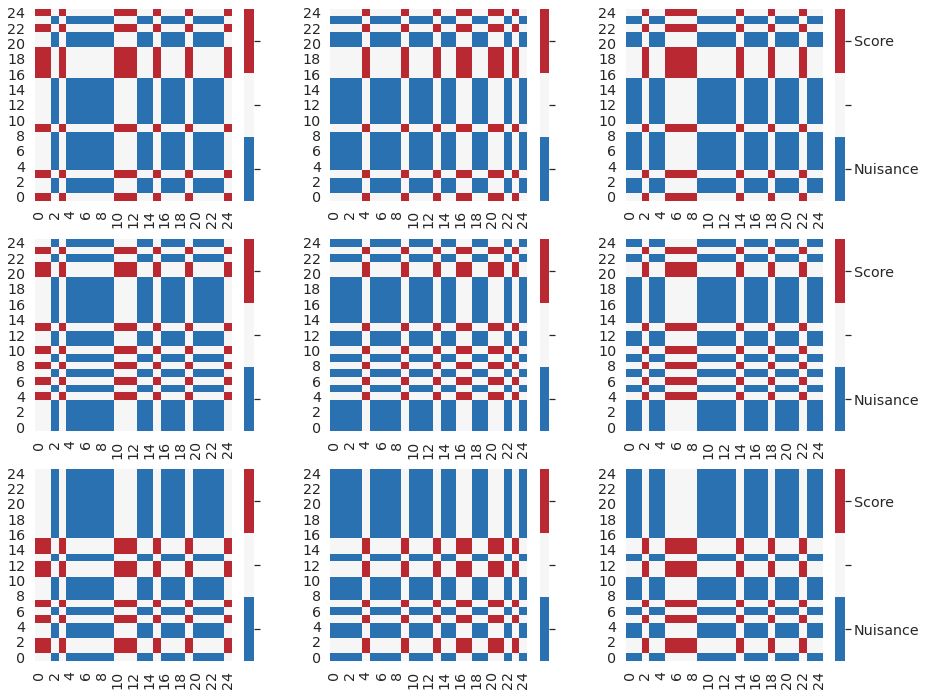

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



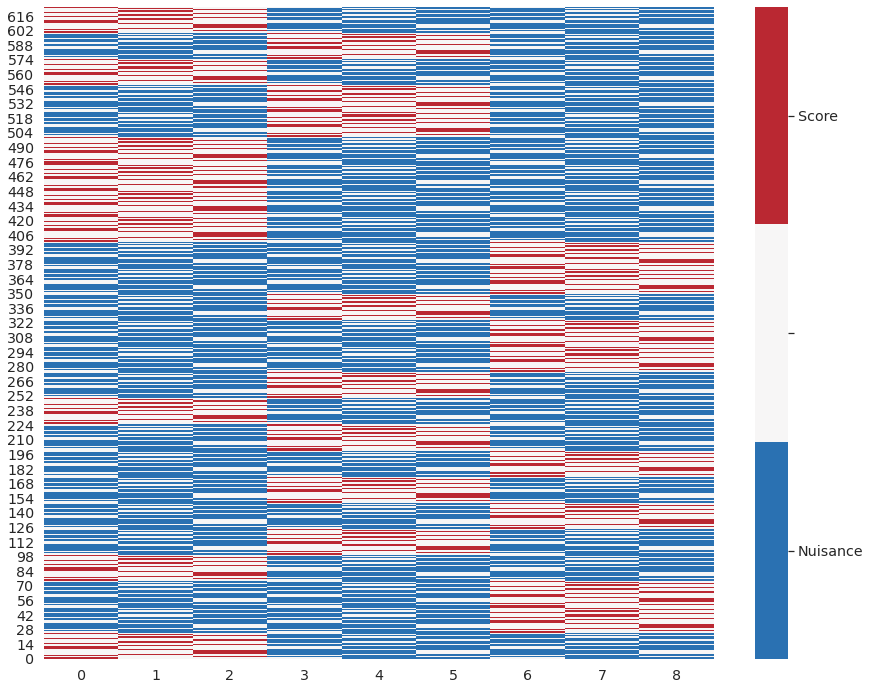

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])